In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
from sklearn.model_selection import train_test_split

LOAD DATASET

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck",
]
print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)
    

Train: (50000, 32, 32, 3) (50000, 1)
Test : (10000, 32, 32, 3) (10000, 1)


In [3]:

def describe_dataset(x_train, y_train, class_names):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_train[i])
        plt.xlabel(class_names[y_train[i][0]])
    plt.tight_layout()
    plt.savefig("cifar10_samples.png")
    plt.close()
    plt.show()
    return (x_train, y_train), (x_test, y_test), class_names

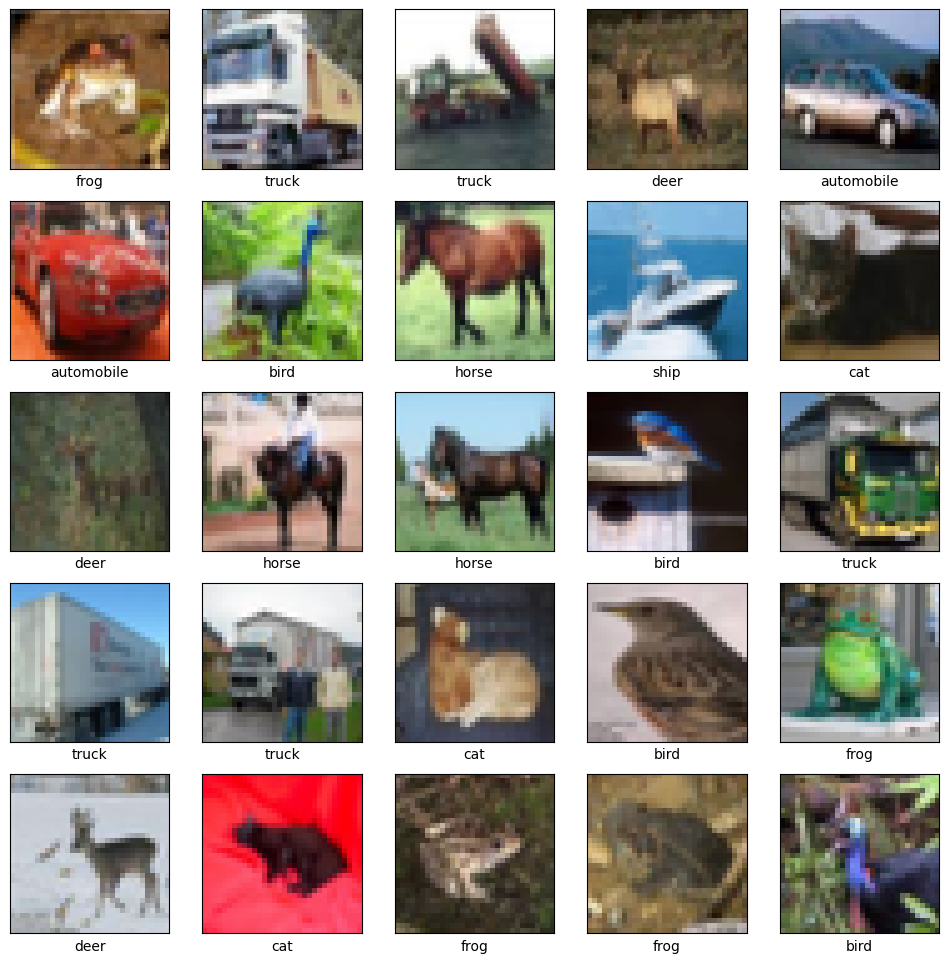

In [4]:
plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i][0]])

2. Preprocessing: normalization, split, one-hot, resizing helper

In [7]:
# 2. Preprocessing
# ---------------------------------------------------------------------
from sklearn.model_selection import train_test_split

def preprocess_data(x_train, y_train, x_test, y_test, num_classes=10, resize_to=None):
    """
    Preprocess dataset:
      - convert tensors to numpy if needed
      - normalize pixel values to [0,1]
      - optional resizing (resize_to -> (height, width))
      - train/validation split (stratified)
      - convert labels to one-hot
    Returns:
      (x_train, y_train_cat), (x_val, y_val_cat), (x_test, y_test_cat)
    """
    # convert TensorFlow tensors to numpy arrays if necessary
    try:
        if tf.is_tensor(x_train):
            x_train = x_train.numpy()
        if tf.is_tensor(x_test):
            x_test = x_test.numpy()
        if tf.is_tensor(y_train):
            y_train = y_train.numpy()
        if tf.is_tensor(y_test):
            y_test = y_test.numpy()
    except NameError:
        # tf is not defined here for some reason; assume inputs are numpy arrays already
        pass

    # normalize images
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0

    # optional resizing
    if resize_to is not None:
        x_train = np.array([tf.image.resize(img, resize_to).numpy() for img in x_train])
        x_test = np.array([tf.image.resize(img, resize_to).numpy() for img in x_test])

    # ensure labels are 1D for stratify
    y_train = y_train.reshape(-1)
    y_test = y_test.reshape(-1)

    # train/validation split
    x_train, x_val, y_train, y_val = train_test_split(
        x_train,
        y_train,
        test_size=0.2,
        stratify=y_train,
        random_state=42,
    )

    # convert labels to categorical (one-hot)
    y_train_cat = to_categorical(y_train, num_classes)
    y_val_cat = to_categorical(y_val, num_classes)
    y_test_cat = to_categorical(y_test, num_classes)

    return (x_train, y_train_cat), (x_val, y_val_cat), (x_test, y_test_cat)

In [6]:
# Print the shapes of the preprocessed data
print("x_train:", x_train.shape, x_train.dtype)
print("y_train_cat:", y_train_cat.shape, y_train_cat.dtype)
print("x_val:", x_val.shape)
print("y_val_cat:", y_val_cat.shape)
print("x_test:", x_test.shape)
print("y_test_cat:", y_test_cat.shape)

x_train: (50000, 32, 32, 3) uint8


NameError: name 'y_train_cat' is not defined

In [ ]:
# Custom CNN architectures
# ---------------------------------------------------------------------
def build_simple_cnn(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape),
            # Max pooling layer to reduce spatial dimensions by a factor of 2
            layers.MaxPooling2D((2, 2)),
            # Second convolutional layer with 64 filters, 3x3 kernel, ReLU activation
            layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
            # Another max pooling layer to reduce size further
            layers.MaxPooling2D((2, 2)),
            # Flatten the 2D feature maps into a 1D vector for dense layers
            layers.Flatten(),
            # Fully connected (dense) layer with 128 neurons and ReLU activation
            #Learns intermediate features from the previous layers
            layers.Dense(128, activation="relu"),
            #50% dropout for regularization
            layers.Dropout(0.5),
            # Output layer with 10 neurons (for 10 classes) and softmax activation
            #Produces the final probabilities for each class.
            layers.Dense(10, activation="softmax"),
        ]
    )
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

# Build and summarize the model
model = build_simple_cnn(input_shape=(32, 32, 3), num_classes=10)
model.summary()



d:\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile and train the simple CNN model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train_cat, epochs=10, validation_data=(x_val, y_val_cat))

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.3872 - loss: 1.6690 - val_accuracy: 0.5488 - val_loss: 1.2833
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.5162 - loss: 1.3492 - val_accuracy: 0.5907 - val_loss: 1.1452
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.5648 - loss: 1.2155 - val_accuracy: 0.6397 - val_loss: 1.0279
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.5922 - loss: 1.1354 - val_accuracy: 0.6417 - val_loss: 1.0040
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.6160 - loss: 1.0770 - val_accuracy: 0.6632 - val_loss: 0.9484
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.6371 - loss: 1.0208 - val_accuracy: 0.6678 - val_loss: 0.9451
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.6528 - loss: 0.9722 - val_accuracy: 0.6817 - val_loss: 0.9101
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.6699 -

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict class probabilities
y_pred_probs = model.predict(x_test)

# Convert probabilities to class predictions
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test  # original integer labels

# Compute metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.6767
Precision: 0.6823
Recall: 0.6767
F1 Score: 0.6741


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.73      0.69      0.71      1000
  automobile       0.83      0.79      0.81      1000
        bird       0.61      0.48      0.54      1000
         cat       0.49      0.48      0.48      1000
        deer       0.55      0.71      0.62      1000
         dog       0.66      0.51      0.57      1000
        frog       0.65      0.85      0.74      1000
       horse       0.78      0.70      0.74      1000
        ship       0.73      0.84      0.78      1000
       truck       0.80      0.72      0.76      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.67     10000
weighted avg       0.68      0.68      0.67     10000



In [ ]:
print("x_test:", x_test.shape, x_test.dtype)
print("y_test:", y_test.shape, y_test.dtype)

y_pred_probs = model.predict(x_test)
print("y_pred_probs shape:", y_pred_probs.shape)

# Convert to indices
y_pred = y_pred_probs.argmax(axis=1)
print("y_pred shape:", y_pred.shape)
print("y_pred[:20]:", y_pred[:20])

if y_test.ndim > 1:
    y_true = y_test.argmax(axis=1)
else:
    y_true = y_test

print("y_true shape:", y_true.shape)
print("y_true[:20]:", y_true[:20])

x_test: (10000, 32, 32, 3) float32
y_test: (10000, 1) uint8
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
y_pred_probs shape: (10000, 10)
y_pred shape: (10000,)
y_pred[:20]: [3 8 8 0 6 6 1 6 3 1 8 9 6 7 9 8 5 4 8 6]
y_true shape: (10000,)
y_true[:20]: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


y_true shape: (10000,)
y_true[:20]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6]
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


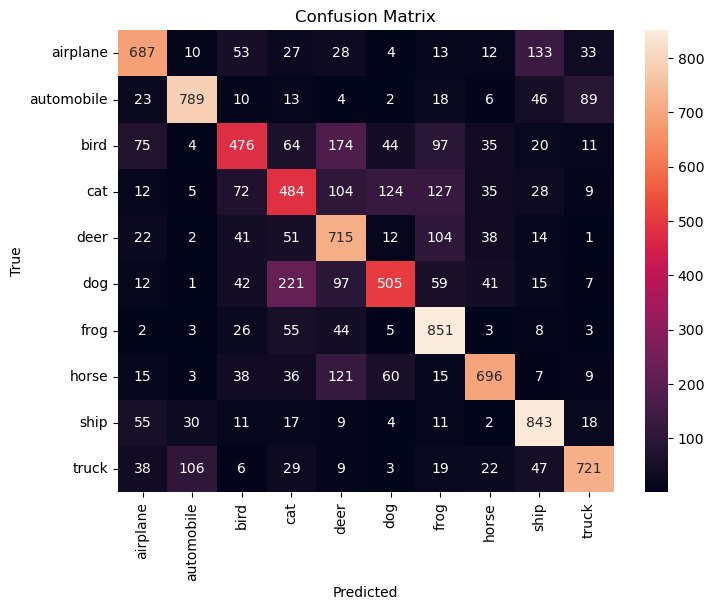

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1) Fix labels to 1D
y_true = y_test.reshape(-1)          # or y_true = np.squeeze(y_test)

print("y_true shape:", y_true.shape)     # (10000,)
print("y_true[:20]:", y_true[:20])

# 2) Predict
y_pred_probs = model.predict(x_test)
y_pred = y_pred_probs.argmax(axis=1)

# 3) Confusion matrix
cm = confusion_matrix(y_true, y_pred)

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import numpy as np

# y_pred_probs already computed: model.predict(x_test)
y_pred = np.array(y_pred)       # shape (10000,)
y_true = np.array(y_true)       # shape (10000,)
X_test_np = x_test              # already NumPy for CIFAR-10

In [ ]:
y_true = y_true.reshape(-1)

In [ ]:
# CIFAR-10 class names
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# Confusing class pairs to inspect (indices in CIFAR-10)
confusing_pairs = [
    (0, 8),  # airplane vs ship
    (1, 9),  # automobile vs truck
    (2, 4),  # bird vs deer
    (3, 5),  # cat vs dog
]

In [ ]:
import matplotlib.pyplot as plt

def show_confusion_examples(y_true, y_pred, X, class1, class2, n=5):
    # indices where class1 was mistaken for class2, and vice versa
    idx_confused_1 = np.where((y_true == class1) & (y_pred == class2))[0]
    idx_confused_2 = np.where((y_true == class2) & (y_pred == class1))[0]

    fig, axes = plt.subplots(2, n, figsize=(15, 5))
    fig.suptitle(f'Confusions: {class_names[class1]} :left_right_arrow: {class_names[class2]}',
                 fontsize=16)

    # row 0: true = class1, predicted = class2
    for i in range(n):
        ax = axes[0, i]
        if i < len(idx_confused_1):
            img = X[idx_confused_1[i]]
            ax.imshow(img)             # 32x32x3 RGB
            ax.set_title(f"True: {class_names[class1]}\nPred: {class_names[class2]}")
        ax.axis('off')

    # row 1: true = class2, predicted = class1
    for i in range(n):
        ax = axes[1, i]
        if i < len(idx_confused_2):
            img = X[idx_confused_2[i]]
            ax.imshow(img)
            ax.set_title(f"True: {class_names[class2]}\nPred: {class_names[class1]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

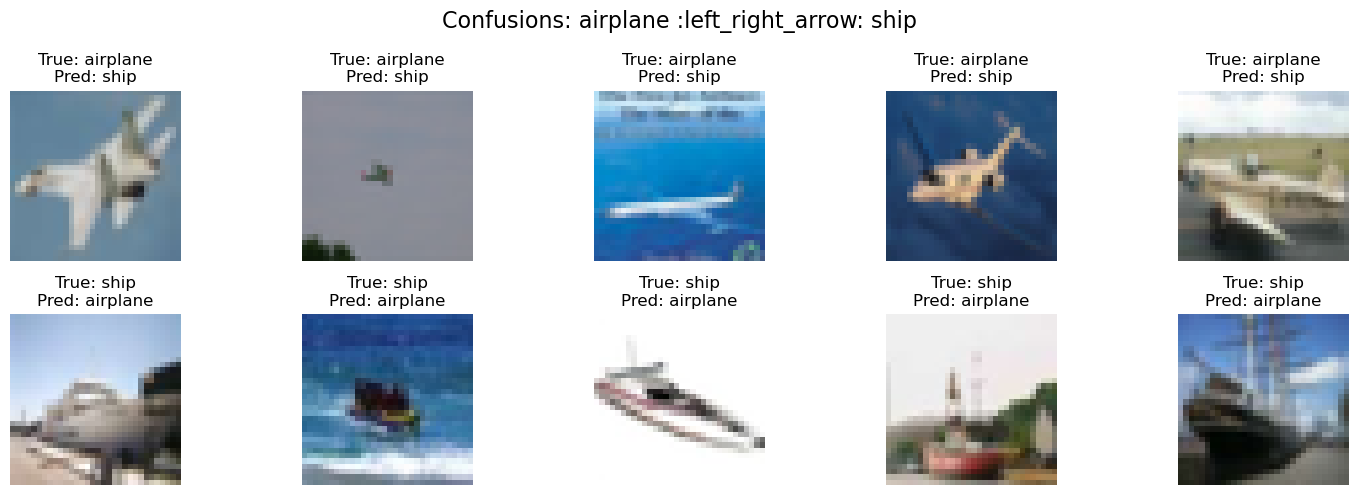

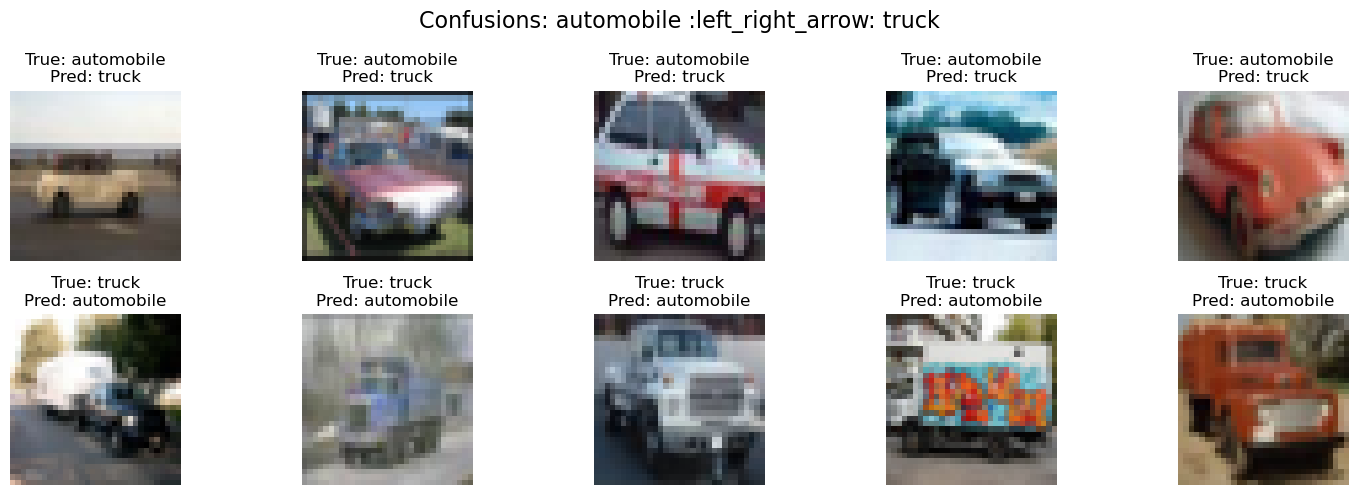

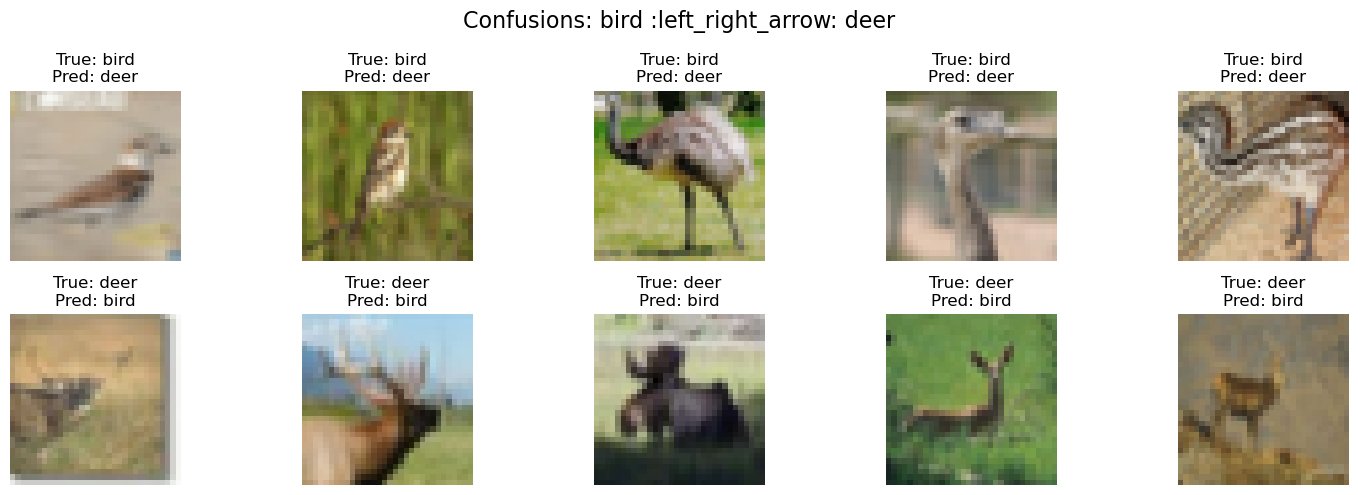

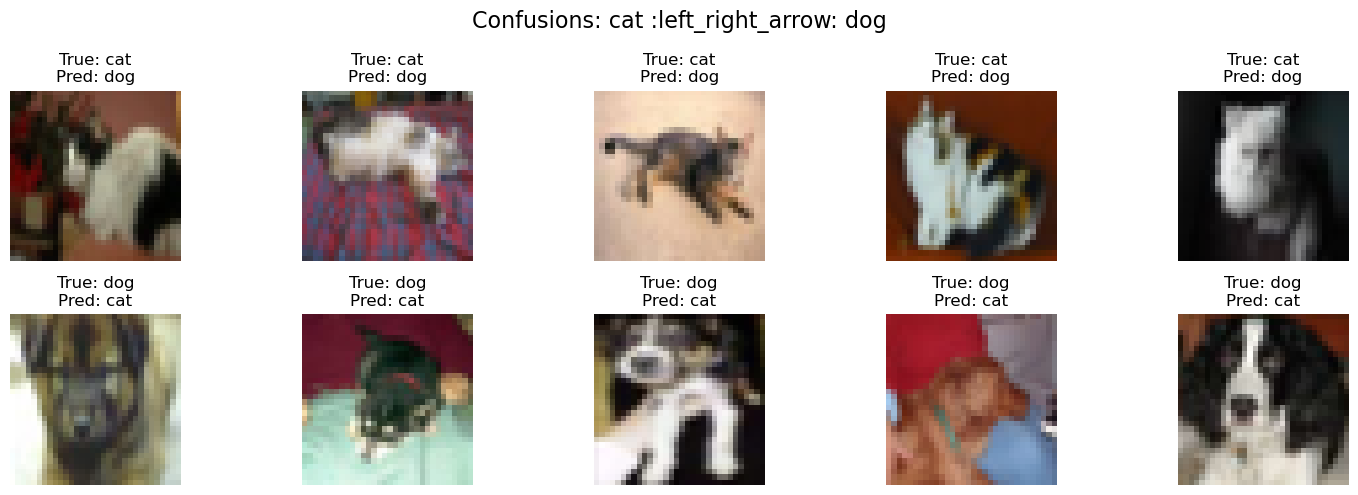

In [ ]:
for class1, class2 in confusing_pairs:
    show_confusion_examples(y_true, y_pred, X_test_np, class1, class2)

Deeper CNN Model

In [ ]:
# Define deeper CNN model
def build_deeper_cnn(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_deeper = build_deeper_cnn(input_shape=(32, 32, 3), num_classes=10)

# Setup EarlyStopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',   # metric to monitor
    patience=3,           # stop if no improvement after 3 epochs
    restore_best_weights=True
)

# Train the model with early stopping
history = model_deeper.fit(
    x_train, y_train_cat,
    epochs=60,             # large max epochs, training will stop early if needed
    batch_size=128,
    validation_data=(x_val, y_val_cat),
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model_deeper.evaluate(x_test, y_test_cat)
print(f"Test accuracy with early stopping: {accuracy:.4f}")


Epoch 1/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.3226 - loss: 1.8153 - val_accuracy: 0.4645 - val_loss: 1.4670
Epoch 2/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.4807 - loss: 1.4266 - val_accuracy: 0.5319 - val_loss: 1.2994
Epoch 3/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.5436 - loss: 1.2730 - val_accuracy: 0.5838 - val_loss: 1.1767
Epoch 4/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.5916 - loss: 1.1553 - val_accuracy: 0.6152 - val_loss: 1.0813
Epoch 5/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.6264 - loss: 1.0674 - val_accuracy: 0.6049 - val_loss: 1.1117
Epoch 6/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.6474 - loss: 1.0047 - val_accuracy: 0.6637 - val_loss: 0.9543
Epoch 7/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.6679 - loss: 0.9485 - val_accuracy: 0.6777 - val_loss: 0.9146
Epoch 8/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.6931 - loss: 0.8806 - 

In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize images to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Optional: create validation split
x_val = x_train[40000:]
y_val = y_train[40000:]
x_train = x_train[:40000]
y_train = y_train[:40000]

# Build model (similar to your screenshot but for 32x32x3)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same',
           input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # integer labels
              metrics=['accuracy'])

d:\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TRAIN EARLY STOPPING

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    epochs=60,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
    verbose=2
)

loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {accuracy:.4f}")

Epoch 1/60
625/625 - 16s - 26ms/step - accuracy: 0.3740 - loss: 1.7182 - val_accuracy: 0.5237 - val_loss: 1.3738
Epoch 2/60
625/625 - 14s - 23ms/step - accuracy: 0.4991 - loss: 1.3898 - val_accuracy: 0.5906 - val_loss: 1.1684
Epoch 3/60
625/625 - 16s - 25ms/step - accuracy: 0.5542 - loss: 1.2552 - val_accuracy: 0.6177 - val_loss: 1.0769
Epoch 4/60
625/625 - 16s - 25ms/step - accuracy: 0.5890 - loss: 1.1562 - val_accuracy: 0.6391 - val_loss: 1.0217
Epoch 5/60
625/625 - 16s - 25ms/step - accuracy: 0.6153 - loss: 1.0945 - val_accuracy: 0.6685 - val_loss: 0.9512
Epoch 6/60
625/625 - 16s - 25ms/step - accuracy: 0.6313 - loss: 1.0324 - val_accuracy: 0.6716 - val_loss: 0.9353
Epoch 7/60
625/625 - 16s - 25ms/step - accuracy: 0.6472 - loss: 0.9917 - val_accuracy: 0.6858 - val_loss: 0.9046
Epoch 8/60
625/625 - 16s - 25ms/step - accuracy: 0.6620 - loss: 0.9512 - val_accuracy: 0.6815 - val_loss: 0.9092
Epoch 9/60
625/625 - 16s - 25ms/step - accuracy: 0.6764 - loss: 0.9125 - val_accuracy: 0.6867 - 

In [ ]:
import tensorflow as tf

model_more_layers = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

model_more_layers.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

d:\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


DATA AUGMENTATION

In [ ]:
history_aug = model_more_layers.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=20,
    validation_data=(x_test, y_test)
)

loss_aug, accuracy_aug = model_more_layers.evaluate(x_test, y_test)
print(f"Test accuracy with data augmentation: {accuracy_aug:.4f}")

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 117s 143ms/step - accuracy: 0.4131 - loss: 1.6073 - val_accuracy: 0.5019 - val_loss: 1.3998
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 99s 126ms/step - accuracy: 0.5549 - loss: 1.2477 - val_accuracy: 0.6147 - val_loss: 1.0774
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 87s 111ms/step - accuracy: 0.6131 - loss: 1.0939 - val_accuracy: 0.6589 - val_loss: 0.9629
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 92s 118ms/step - accuracy: 0.6499 - loss: 0.9898 - val_accuracy: 0.6873 - val_loss: 0.9083
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 96s 122ms/step - accuracy: 0.6787 - loss: 0.9178 - val_accuracy: 0.7283 - val_loss: 0.7774
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 102s 131ms/step - accuracy: 0.6929 - loss: 0.8723 - val_accuracy: 0.7193 - val_loss: 0.7972
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 101s 130ms/step - accuracy: 0.7111 - loss: 0.8266 - val_accuracy: 0.7326 - val_loss: 0.7811
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 136s 173ms/step - accuracy: 0.7238 - los